<a href="https://colab.research.google.com/github/InhyeokYoo/Pytorch-study/blob/master/Ch%207.%20%ED%95%99%EC%8A%B5%20%EC%8B%9C%20%EC%83%9D%EA%B8%B8%20%EC%88%98%20%EC%9E%88%EB%8A%94%20%EB%AC%B8%EC%A0%9C/%204.%20Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation
- Scale
- Crop
- Flip
- Rotate (using PIL Transform)

# 1. Setting

In [0]:
# Import libraries

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Set hyper-parameters

batch_size = 256
learning_rate = 0.0002
num_epoch = 10

# 2. Data

In [0]:
# Download data

mnist_train = dset.MNIST('./', train=True,
                         transform=transforms.Compose(
                             [transforms.Resize(34),                            # 28x28을 34x34로 늘림.
                              transforms.CenterCrop(28),                        # 중앙 28x28을 뽑아냄.
                              transforms.RandomHorizontalFlip(),                # 랜덤하게 좌우반전
                              transforms.Lambda(lambda x: x.rotate(90)),        # 이미지를 텐서로 변경한다.
                              transforms.ToTensor(),
                              ]
                         ), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

0it [00:00, ?it/s]

9920512it [00:01, 8504708.42it/s]                            


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 130336.03it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:00, 2204298.91it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


8192it [00:00, 50331.62it/s]            


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [0]:
# Set DataLoader

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

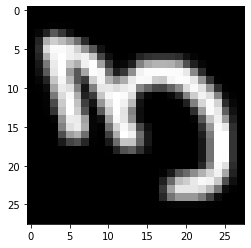

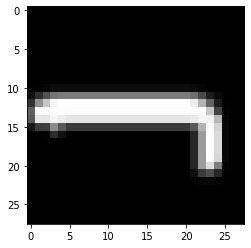

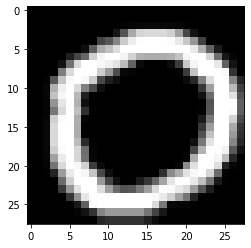

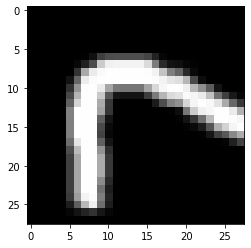

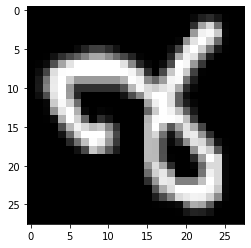

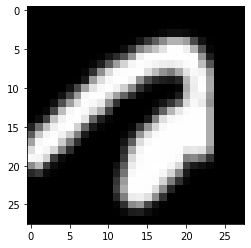

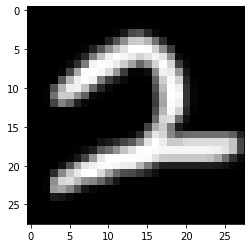

In [0]:
# 이미지를 보면 알수 있듯이 augmentation을 데이터에 맞게 하지 않으면 말도 안되는걸 학습하게 됩니다.
# 90도 돌리거나 좌우반전을 함으로써 의미를 잃어버리는 경우도 있기 때문에 데이터에 맞는 augmentation을 해야합니다.

for idx,(img,label) in enumerate(train_loader):
  plt.imshow(img[0,0,...],cmap="gray")
  plt.show()
  if idx > 5:
    break

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),  # 28 x 28
            nn.ReLU(),
            nn.Conv2d(16,32,3,padding=1), # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2,2),            # 14 x 14
            nn.Conv2d(32,64,3,padding=1), # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2,2)             #  7 x 7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )       
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

cuda:0


In [0]:
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
    if i % 10 == 0:
        print(loss)          

tensor(2.2990, device='cuda:0', grad_fn=<NllLossBackward>)


In [0]:
correct = 0
total = 0

with torch.no_grad():
  for image,label in test_loader:
      x = image.to(device)
      y_= label.to(device)

      output = model.forward(x)
      _,output_index = torch.max(output,1)

      total += label.size(0)
      correct += (output_index == y_).sum().float()

  print("Accuracy of Test Data: {}".format(100*correct/total))